# 实战 Kaggle 比赛：狗的品种识别（ImageNet Dogs）
比赛网址是 https://www.kaggle.com/c/dog-breed-identification

**导包**

In [1]:
import os
import torch
from torch import nn
import torchvision
import d2l_torch as d2l

## 导入整理数据

**下载数据，还是使用小数据，而不是完整数据，只是做一个demo**

In [2]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

下面的代码组织结构基本和上节课一模一样，直接就调用上节课写好的那几个函数

In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

注意：
+ train_valid_test/train/中第一个文件夹里含有一个：.ipynb_notebook的文件夹，要删掉，不然运行的时候会报错
+ 也是和上次一样，所以jupyter lab会自动为这种文件夹添加一个隐藏文件夹？？？

## 图像增广

+ 可以先去看一下图像的尺寸，有(250,258),(395,232)等等
+ 毕竟是搜索然后直接下载的图像，图像主要物体是对的就已经算是质量不错了，就别强求尺寸也给你处理好
+ 因此其实在图像增强的时候，肯定先要裁剪，再做其他操作。
    + 原始图像大概都在256左右，resnet接受的输入是224，
    + 范围定在8%到100%，感觉上8%有点小了，但是去看看数据集，有些图像里狗的占比确实很小，但是这样设置其实没有非常合理
    + 长宽比在0.75~4/3之间，就是3：4与4：3之间，是个比较正常的范围。图像不会太宽，也不会太窄

In [4]:
transform_train=torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224,scale=(0.08,1.0),ratio=(3.0/4.0,4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4,hue=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]) 

transform_test=torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

对于训练的增强：
+ 先把图像尺寸弄标准，都resize成224
+ 然后以0.5的概率决定要不要把狗水平翻转
+ 然后做颜色抖动，包括亮度，对比度，饱和度以及色相
+ 转成Tensor。（这步之前，上面的都是对图像的处理）
+ normalize（转成tensor才可以normalize），使用的均值和方差是ImageNet的

**所以问题来了，为什么cifar10同样也是来自ImageNet的，但是就用了自己的均值和方差，而这个狗品种数据集也是来自ImageNet，却使用ImageNet的均值和方差❓❓❓**

对于测试的增强：
+ 先resize，如果只有一个参数`s`，那就是短边去适配这个值，然后抽出(s,s)这样大小的图像
+ 然后从中心crop，这个增强还是很粗糙啊
+ 然后同样，转成向量之后，使用ImageNet的均值和方差去normalize

## 制作dataset(dataloader)

In [5]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),transform=transform_train) 
    for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),transform=transform_test) 
    for folder in ['valid', 'test']]


train_iter, train_valid_iter = [torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,drop_last=True)
    for dataset in (train_ds, train_valid_ds)]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,drop_last=False)

和之前也是一模一样的

## 微调预训练模型

注意，这个demo使用了微调，上一个没有微调（用了resnet18的结构，但是没有下载预训练模型的权重）

In [14]:
def get_net(devices):
    finetune_net=nn.Sequential()
    finetune_net.features=torchvision.models.resnet34(pretrained=True)
    finetune_net.output_new=nn.Sequential(nn.Linear(1000,256),nn.ReLU(),nn.Linear(256,120))
    
    finetune_net=finetune_net.to(devices[0])
    for param in finetune_net.features.parameters():
        param.requires_grad=False
    
    return finetune_net

## 损失函数

In [9]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

## 训练函数

In [11]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD(
        (param for param in net.parameters() if param.requires_grad), lr=lr,
        momentum=0.9, weight_decay=wd)  
    # 特征层部分的参数不予更新，只看那两个新加的Linear层的参数
    
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.cpu().detach()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## 训练和验证

In [15]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay,net = 2, 0.9,get_net(devices)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/huangshan/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
95.0%

打印了一下 `net`，果然，上面的那种语法，其实就是简化版本的`add_module`

In [19]:
net

Sequential(
  (features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [17]:
net.features

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
net.output_new

Sequential(
  (0): Linear(in_features=1000, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=120, bias=True)
)

In [20]:
devices

[device(type='cpu')]

train loss 1.510, valid loss 1.441
10.5 examples/sec on [device(type='cpu')]


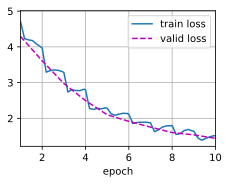

In [21]:
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)

还好这个网络固定了特征部分，只需要训练两个线性层，而且batch_size=32，所以我这个没有GPU，内存只有8G的机子也能跑动。感动😫😫😫

## 查看测试集结果

验证集也不多，每个类别就一张图片，也就一共120张新图，没必要重新训练一遍，直接用上面单纯train数据集得到的网络，来进行test文件夹中图像的推理，看一下最后效果就行，应该也不会差距很大

In [36]:
# net = get_net(devices)
# train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
#       lr_decay)

preds = []
for data, label in test_iter:
    rs=net(data.to(devices[0]))
    print(rs.size())
    output = torch.nn.functional.softmax(rs, dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(
    os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(
            i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')

torch.Size([10, 120])


一共是10张测试图片，dim应该为1，对120维度做softmax

In [37]:
preds[0].shape

(120,)

In [38]:
preds[0].sum()

1.0